# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
```

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
print("Brain Name: ", brain_name)
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print("State sizes: ", states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 4.1 Import settings
Initiate the environment

In [1]:
import os
import torch 
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment
import numpy as np
from maddpg_N import *
# !pip install progressbar2
import progressbar as pb
from torch.utils.tensorboard import SummaryWriter

#---------------Environment set-up--------------------#
env =UnityEnvironment(file_name='Tennis_Linux_NoVis/Tennis.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Initiate environment
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]            # get the current state
score = 0

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
state_size = len(state)
print('States have length:', state_size)
#agent = DDPGAgent(state_size=state_size, action_size=action_size, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Number of actions: 2
States have length: 24


ddpg_body_dim = [(256,128),(256,128)]

maddpg = MADDPG(state_size, action_size, ddpg_body_dim=ddpg_body_dim, seed=0, batch_size=128, buffer_size=int(10e5), tau=1e-3,\
                gamma=0.99, decay_noise=0.99,lr_actor=1e-3, lr_critic=1e-3, weight_decay=1e-6, device=device)

In [2]:
def main():
    """
    Multiagent Deep deterministic Policy Gradient (MADDPG)
    This specific MMADDPG will learn how to play a game of tennis. There are 24 states-observables and 2 action-dimensions for
    each agent. 
        
    """
    # ---------------Configuration----------------#
     # Episodes and Trajectory
    n_episodes = 5000
    trajectory_length = 1000
    batch_size = 256
    
    # Model Parameters
    ddpg_body_dim = [(400,300),(400,300)]
    seed = 10
    buffer_size = int(1e5)
    tau = 5e-3
    gamma = 0.995
    decay_noise = 0.999999
    lr_actor = 1e-4
    lr_critic = 5e-3
    weight_decay = 0
    multiple_learning = 5
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("Device used: ", device)
    maddpg = MADDPG(state_size, action_size, n_agents, linear_net_dim=ddpg_body_dim, seed=seed,\
                    batch_size=batch_size, buffer_size=buffer_size, tau=tau, gamma=gamma,\
                    decay_noise=decay_noise,lr_actor=lr_actor, lr_critic=lr_critic,\
                    weight_decay=weight_decay, device=device)
    
    # Save configurations
    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)
    
    # initialize logging of rewards
    logger = SummaryWriter(log_dir=log_path)
    agent0_reward = deque(maxlen=100)
    agent1_reward = deque(maxlen=100)

    all_scores = []
    all_avg_scores = []
    scores_100 = deque(maxlen=100)    
    
    widget = ["Training Status: ", pb.Timer(), ' ', pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar()]
    #timer = pb.progressbar(widgets=widget, maxval=n_episodes).start()
    
    ##############################################################################
    #---------------------------Training Commence--------------------------------#
    for i_episode in pb.progressbar(range(1, n_episodes+1), widgets=widget):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations           # get the current state
        scores = np.zeros(len(env_info.agents))
        for t in range(trajectory_length):
        
            actions = maddpg.act(states, noise=1.0)  # state[n_agent,dim], noise=1.0 (on)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state: array -  (num_agent, state_feature_dim)
            rewards = env_info.rewards                   # get the reward: list - [num_agent]
            dones = env_info.local_done                  # see if episode has finished: list - [num_agent]
            
            # Add to memory 
            maddpg.memory.add_experience(states,actions,rewards, next_states,dones)
            if (len(maddpg.memory) > batch_size) and (i_episode % 4 == 0):
                for i in range(multiple_learning):
                    for agent_i in range(2):
                        maddpg.step(batch_size, agent_i, logger)
                    maddpg.update_targets()
                    
            scores += rewards                               # update the score
            states = next_states                             # roll over the state to next time step
            if np.any(dones):# and t>100:
                break
            
            
            
        # LR Update once after every episode
        ## maddpg.lr_update()                 
           
        agent0_reward.append(scores[0])       # save latest score into a variable containing the 100 latest scores
        agent1_reward.append(scores[1])
        all_scores.append(np.max(scores))
        scores_100.append(np.max(scores))
        avg_score = np.mean(scores_100)
        all_avg_scores.append(avg_score)
                

        if i_episode % 100 ==0 or i_episode==n_episodes-1:
            avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward)]
            for agent_i , avg_reward in enumerate(avg_rewards):
                logger.add_scalar("Agent%i/mean_episode_rewards"% agent_i, avg_reward, i_episode)
            
        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore: {}\t 100 Moving Average Score: {}, OUNOISE: {}, pl {}, cl {} '.format(i_episode, scores, avg_score, maddpg.noise.state*maddpg.decay_noise, maddpg.pl, maddpg.cl))
            
        # save model
        agent_checkpoints = []
        if np.mean(avg_score)>=0.5 and i_episode >=3000:
            
            print('\nEnvironment solved in {:d} episodes!\t Score: {:5.2f}\t 10 Moving Average Score: {:.2f}'.format(i_episode, score, avg_score))
            for agent_i in range(2):
                checkpoint = {
                    'actor_params_{}'.format(agent_i): maddpg.maddpg_agent[agent_i].actor_local.state_dict(),
                    'critic_params_{}'.format(agent_i): maddpg.maddpg_agent[agent_i]
                    }   
                agent_checkpoints.append(checkpoint)
            print("\nModel saved!💎🙌")
            torch.save(agent_checkpoints, model_dir+'checkpoint.pt')
            
            logger.close()
            return (all_scores, all_avg_scores, maddpg)
    
    logger.close()
    return (all_scores, all_avg_scores, maddpg)

output_tuple = main()
env.close()

Device used:  cuda:0


Training Status: Elapsed Time: 0:00:53   2% ETA:   0:43:25 |                  |

Episode 100	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.0, OUNOISE: [0.43958842 0.49908495], pl -0.015521762892603874, cl 3.551291229086928e-06 


Training Status: Elapsed Time: 0:01:52   4% ETA:   0:44:42 |                  |

Episode 200	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.0, OUNOISE: [0.3610673  0.36563752], pl 0.00427026953548193, cl 6.345249516925833e-07 


Training Status: Elapsed Time: 0:02:51   6% ETA:   0:44:30 |#                 |

Episode 300	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.0, OUNOISE: [0.34294125 0.34163154], pl 0.005008047912269831, cl 2.0842193748649152e-07 


Training Status: Elapsed Time: 0:03:48   8% ETA:   0:43:42 |#                 |

Episode 400	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.0, OUNOISE: [0.25023591 0.23782599], pl 0.005548825487494469, cl 1.176438217953546e-07 


Training Status: Elapsed Time: 0:04:47  10% ETA:   0:42:59 |#                 |

Episode 500	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.004500000085681677, OUNOISE: [0.16003415 0.19090332], pl -0.10613565146923065, cl 0.0015410983469337225 


Training Status: Elapsed Time: 0:05:48  12% ETA:   0:42:28 |##                |

Episode 600	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.006400000117719173, OUNOISE: [0.07940838 0.11575006], pl -0.03115496039390564, cl 0.00017214607214555144 


Training Status: Elapsed Time: 0:06:46  14% ETA:   0:41:35 |##                |

Episode 700	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.0, OUNOISE: [0.11614191 0.08954867], pl -0.0021545076742768288, cl 6.016000406816602e-05 


Training Status: Elapsed Time: 0:07:50  16% ETA:   0:41:03 |##                |

Episode 800	Score: [ 0.1  -0.01]	 100 Moving Average Score: 0.0030000000447034836, OUNOISE: [0.06630203 0.07301685], pl 0.0021152189001441, cl 1.5330411770264618e-05 


Training Status: Elapsed Time: 0:09:19  18% ETA:   0:42:27 |###               |

Episode 900	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.029000000432133674, OUNOISE: [0.05650497 0.04502879], pl 0.0018098376458510756, cl 4.659958904085215e-06 


Training Status: Elapsed Time: 0:10:29  20% ETA:   0:41:53 |###               |

Episode 1000	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.018600000292062758, OUNOISE: [0.03481874 0.02240952], pl 0.002317408099770546, cl 1.3431227671389934e-05 


Training Status: Elapsed Time: 0:11:43  22% ETA:   0:41:34 |###               |

Episode 1100	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.022700000461190938, OUNOISE: [0.02216584 0.01984081], pl 0.003493257099762559, cl 7.339618150581373e-06 


Training Status: Elapsed Time: 0:13:12  24% ETA:   0:41:46 |####              |

Episode 1200	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.035400000549852845, OUNOISE: [0.01353248 0.01660098], pl 0.008167692460119724, cl 3.780327460845001e-05 


Training Status: Elapsed Time: 0:14:11  26% ETA:   0:40:20 |####              |

Episode 1300	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.0, OUNOISE: [0.00581346 0.01206033], pl 0.005328514613211155, cl 3.5068936995230615e-05 


Training Status: Elapsed Time: 0:15:14  28% ETA:   0:39:10 |#####             |

Episode 1400	Score: [-0.01  0.  ]	 100 Moving Average Score: 0.00490000007674098, OUNOISE: [0.00793715 0.00910886], pl 0.007223003543913364, cl 9.078585208044387e-06 


Training Status: Elapsed Time: 0:16:23  30% ETA:   0:38:11 |#####             |

Episode 1500	Score: [ 0.1  -0.01]	 100 Moving Average Score: 0.019000000283122064, OUNOISE: [0.0040463  0.00729561], pl 0.004902405198663473, cl 1.762272404448595e-05 


Training Status: Elapsed Time: 0:18:10  32% ETA:   0:38:37 |#####             |

Episode 1600	Score: [0.   0.09]	 100 Moving Average Score: 0.06730000106617809, OUNOISE: [0.00460501 0.00318762], pl -0.019351430237293243, cl 4.428644751897082e-05 


Training Status: Elapsed Time: 0:20:45  34% ETA:   0:40:18 |######            |

Episode 1700	Score: [0.   0.09]	 100 Moving Average Score: 0.0972000015899539, OUNOISE: [0.00175887 0.00188098], pl -0.03380598500370979, cl 3.748213202925399e-05 


Training Status: Elapsed Time: 0:23:29  36% ETA:   0:41:46 |######            |

Episode 1800	Score: [0.09 0.1 ]	 100 Moving Average Score: 0.08710000140592455, OUNOISE: [0.00062036 0.00077573], pl -0.05562608689069748, cl 7.568002911284566e-05 


Training Status: Elapsed Time: 0:27:32  38% ETA:   0:44:56 |######            |

Episode 1900	Score: [0.09 0.1 ]	 100 Moving Average Score: 0.12270000187680125, OUNOISE: [0.00026914 0.00030463], pl -0.08476269245147705, cl 0.00019760863506235182 


Training Status: Elapsed Time: 0:37:15  40% ETA:   0:55:52 |#######           |

Episode 2000	Score: [0.39000001 0.40000001]	 100 Moving Average Score: 0.44720000671222804, OUNOISE: [7.30390295e-06 7.47057153e-06], pl -0.1786901354789734, cl 0.0007219853578135371 


Training Status: Elapsed Time: 0:55:05  42% ETA:   1:16:04 |#######           |

Episode 2100	Score: [0.2  0.19]	 100 Moving Average Score: 0.9334000139310956, OUNOISE: [4.53047802e-09 6.18987713e-09], pl -0.5359658002853394, cl 0.0016253297217190266 


Training Status: Elapsed Time: 1:04:39  44% ETA:   1:22:17 |#######           |

Episode 2200	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.33600000500679017, OUNOISE: [3.29109378e-10 3.92436948e-10], pl -0.2741609811782837, cl 0.001796020194888115 


Training Status: Elapsed Time: 1:08:23  46% ETA:   1:20:17 |########          |

Episode 2300	Score: [ 0.   -0.01]	 100 Moving Average Score: 0.19400000289082528, OUNOISE: [7.94749523e-11 6.76588936e-11], pl -0.2198607325553894, cl 0.0005700936890207231 


Training Status: Elapsed Time: 1:11:34  48% ETA:   1:17:32 |########          |

Episode 2400	Score: [0.09 0.2 ]	 100 Moving Average Score: 0.14550000218674541, OUNOISE: [2.08019617e-11 2.32053201e-11], pl -0.23062999546527863, cl 0.0007393328123725951 


Training Status: Elapsed Time: 1:16:48  50% ETA:   1:16:48 |#########         |

Episode 2500	Score: [0.   0.09]	 100 Moving Average Score: 0.3346000050380826, OUNOISE: [1.73924334e-12 1.37332090e-12], pl -0.2826077938079834, cl 0.0006616199389100075 


Training Status: Elapsed Time: 1:23:45  52% ETA:   1:17:18 |#########         |

Episode 2600	Score: [0.09 0.2 ]	 100 Moving Average Score: 0.36000000543892385, OUNOISE: [8.55788627e-14 9.38567058e-14], pl -0.32542216777801514, cl 0.0008150253561325371 


Training Status: Elapsed Time: 1:32:00  54% ETA:   1:18:22 |#########         |

Episode 2700	Score: [0.   0.09]	 100 Moving Average Score: 0.36280000558122993, OUNOISE: [7.44809312e-15 4.90934761e-15], pl -0.4749094247817993, cl 0.0018566903891041875 


Training Status: Elapsed Time: 1:38:24  56% ETA:   1:17:19 |##########        |

Episode 2800	Score: [0.1  0.09]	 100 Moving Average Score: 0.25840000389143825, OUNOISE: [5.93109257e-16 3.55285254e-16], pl -0.591118335723877, cl 0.0020956783555448055 


Training Status: Elapsed Time: 1:46:42  58% ETA:   1:17:16 |##########        |

Episode 2900	Score: [0.19 0.2 ]	 100 Moving Average Score: 0.2835000042431057, OUNOISE: [5.89417833e-17 5.45216278e-17], pl -0.6882283687591553, cl 0.0036550057120621204 


Training Status: Elapsed Time: 1:54:29  60% ETA:   1:16:19 |##########        |

Episode 3000	Score: [0.09 0.2 ]	 100 Moving Average Score: 0.30470000460743907, OUNOISE: [4.16681473e-18 3.64326482e-18], pl -0.7530286908149719, cl 0.004702872131019831 


Training Status: Elapsed Time: 2:01:08  62% ETA:   1:14:14 |###########       |

Episode 3100	Score: [0.40000001 0.39000001]	 100 Moving Average Score: 0.25660000383853915, OUNOISE: [5.29992137e-19 6.96730882e-19], pl -0.784199059009552, cl 0.0029475626070052385 


Training Status: Elapsed Time: 2:09:17  64% ETA:   1:12:43 |###########       |

Episode 3200	Score: [0.2  0.09]	 100 Moving Average Score: 0.32680000495165584, OUNOISE: [5.98858729e-20 5.32733200e-20], pl -0.8629867434501648, cl 0.0034966357052326202 


Training Status: Elapsed Time: 2:18:39  66% ETA:   1:11:26 |###########       |

Episode 3300	Score: [0.09 0.1 ]	 100 Moving Average Score: 0.373300005607307, OUNOISE: [2.50153489e-21 2.41768433e-21], pl -0.9385125041007996, cl 0.005577222444117069 


Training Status: Elapsed Time: 2:31:49  70% ETA:   1:05:04 |############      |

Episode 3500	Score: [0.09 0.1 ]	 100 Moving Average Score: 0.23370000353083015, OUNOISE: [7.42171616e-23 8.44676305e-23], pl -0.8658064007759094, cl 0.00261079054325819 


Training Status: Elapsed Time: 2:40:01  72% ETA:   1:02:13 |############      |

Episode 3600	Score: [0.3  0.29]	 100 Moving Average Score: 0.2855000043287873, OUNOISE: [7.05792161e-24 4.92741133e-24], pl -0.8901081085205078, cl 0.005697951652109623 


Training Status: Elapsed Time: 2:46:12  74% ETA:   0:58:23 |#############     |

Episode 3700	Score: [ 0.1  -0.01]	 100 Moving Average Score: 0.257900003939867, OUNOISE: [8.47823745e-25 6.90163784e-25], pl -0.8768290281295776, cl 0.0053515080362558365 


Training Status: Elapsed Time: 3:00:39  78% ETA:   0:50:57 |##############    |

Episode 3900	Score: [0.49000001 0.50000001]	 100 Moving Average Score: 0.20680000316351652, OUNOISE: [1.17479228e-26 1.85531112e-26], pl -0.7563842535018921, cl 0.00425771763548255 


Training Status: Elapsed Time: 3:10:57  80% ETA:   0:47:44 |##############    |

Episode 4000	Score: [-0.01  0.1 ]	 100 Moving Average Score: 0.3225000048801303, OUNOISE: [1.22543839e-27 1.45593402e-27], pl -0.7942472696304321, cl 0.00250994716770947 


Training Status: Elapsed Time: 3:18:09  82% ETA:   0:43:29 |##############    |

Episode 4100	Score: [0.   0.09]	 100 Moving Average Score: 0.26670000413432715, OUNOISE: [1.66382053e-28 1.58311618e-28], pl -0.7648766040802002, cl 0.003701326670125127 


Training Status: Elapsed Time: 3:27:17  84% ETA:   0:39:29 |###############   |

Episode 4200	Score: [ 0.1  -0.01]	 100 Moving Average Score: 0.2972000044584274, OUNOISE: [1.09142165e-29 1.58276193e-29], pl -0.7680888175964355, cl 0.004780474118888378 


Training Status: Elapsed Time: 3:33:30  86% ETA:   0:34:45 |###############   |

Episode 4300	Score: [0.50000001 0.49000001]	 100 Moving Average Score: 0.21420000325888394, OUNOISE: [2.72720170e-30 2.06911601e-30], pl -0.7580874562263489, cl 0.0053833648562431335 


Training Status: Elapsed Time: 3:40:25  88% ETA:   0:30:03 |###############   |

Episode 4400	Score: [0.1  0.19]	 100 Moving Average Score: 0.21140000324696304, OUNOISE: [4.89540865e-31 3.31454993e-31], pl -0.7835450172424316, cl 0.003687141463160515 


Training Status: Elapsed Time: 3:45:52  90% ETA:   0:25:05 |################  |

Episode 4500	Score: [0.09 0.1 ]	 100 Moving Average Score: 0.1843000028654933, OUNOISE: [1.26122767e-31 1.00128698e-31], pl -0.7603170275688171, cl 0.007744855247437954 


Training Status: Elapsed Time: 3:51:14  92% ETA:   0:20:06 |################  |

Episode 4600	Score: [0.1  0.09]	 100 Moving Average Score: 0.16700000252574682, OUNOISE: [2.56628927e-32 1.65991521e-32], pl -0.7440719604492188, cl 0.0035240931902080774 


Training Status: Elapsed Time: 3:58:36  94% ETA:   0:15:13 |################  |

Episode 4700	Score: [0.2  0.19]	 100 Moving Average Score: 0.19890000304207206, OUNOISE: [3.53010368e-33 4.00234780e-33], pl -0.7174626588821411, cl 0.002743916818872094 


Training Status: Elapsed Time: 4:02:56  96% ETA:   0:10:04 |################# |

Episode 4800	Score: [0.   0.09]	 100 Moving Average Score: 0.12610000191256404, OUNOISE: [9.79498965e-34 1.34117924e-33], pl -0.6744831800460815, cl 0.003028222592547536 


Training Status: Elapsed Time: 4:06:08  98% ETA:   0:05:01 |################# |

Episode 4900	Score: [0.2  0.09]	 100 Moving Average Score: 0.10280000161379575, OUNOISE: [7.17337162e-34 7.11435989e-34], pl -0.61927330493927, cl 0.003905226243659854 


Training Status: Elapsed Time: 4:11:10 100% Time:  4:11:10 |##################|


Episode 5000	Score: [0.40000001 0.29      ]	 100 Moving Average Score: 0.14910000229254364, OUNOISE: [2.00880583e-34 1.62883443e-34], pl -0.5011993646621704, cl 0.0021582720801234245 


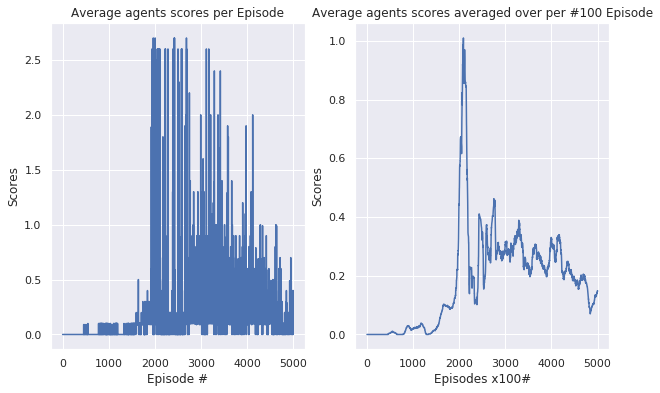

In [7]:
# plot the scores
import seaborn as sns
scores, avg_scores, _  = output_tuple
sns.set()
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(scores)), scores)
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(avg_scores)), avg_scores)

ax1.set(ylabel='Scores', xlabel='Episode #', title="Average agents scores per Episode")
ax2.set(ylabel='Scores', xlabel='Episodes x100#', title="Average agents scores averaged over per #100 Episode")
plt.show()
fig.tight_layout()
fig.savefig("/home/lew/Projects/Continuous-control_/plots/20agents-DDPG_reacher.png")